# sw_audio_dsp pipeline designer

In this file you can generate the DSP pipeline of your choice.

Below you will find 4 cells which can be modified and executed to configure, tune and run the desired pipeline.



1. This is the pipeline design cell. Here you must break the DSP pipeline down into threads and use the provided DSP stages to create a pipeline. Running this cell will produce a diagram showing your pipeline. Make sure to capture each stage in your pipeline as a variable, as it will be needed in the next step.
Note that every time the pipeline cell is changed, the app must be regenerated before the tuning stage can work correctly as the stage indices used for communication may have changed.

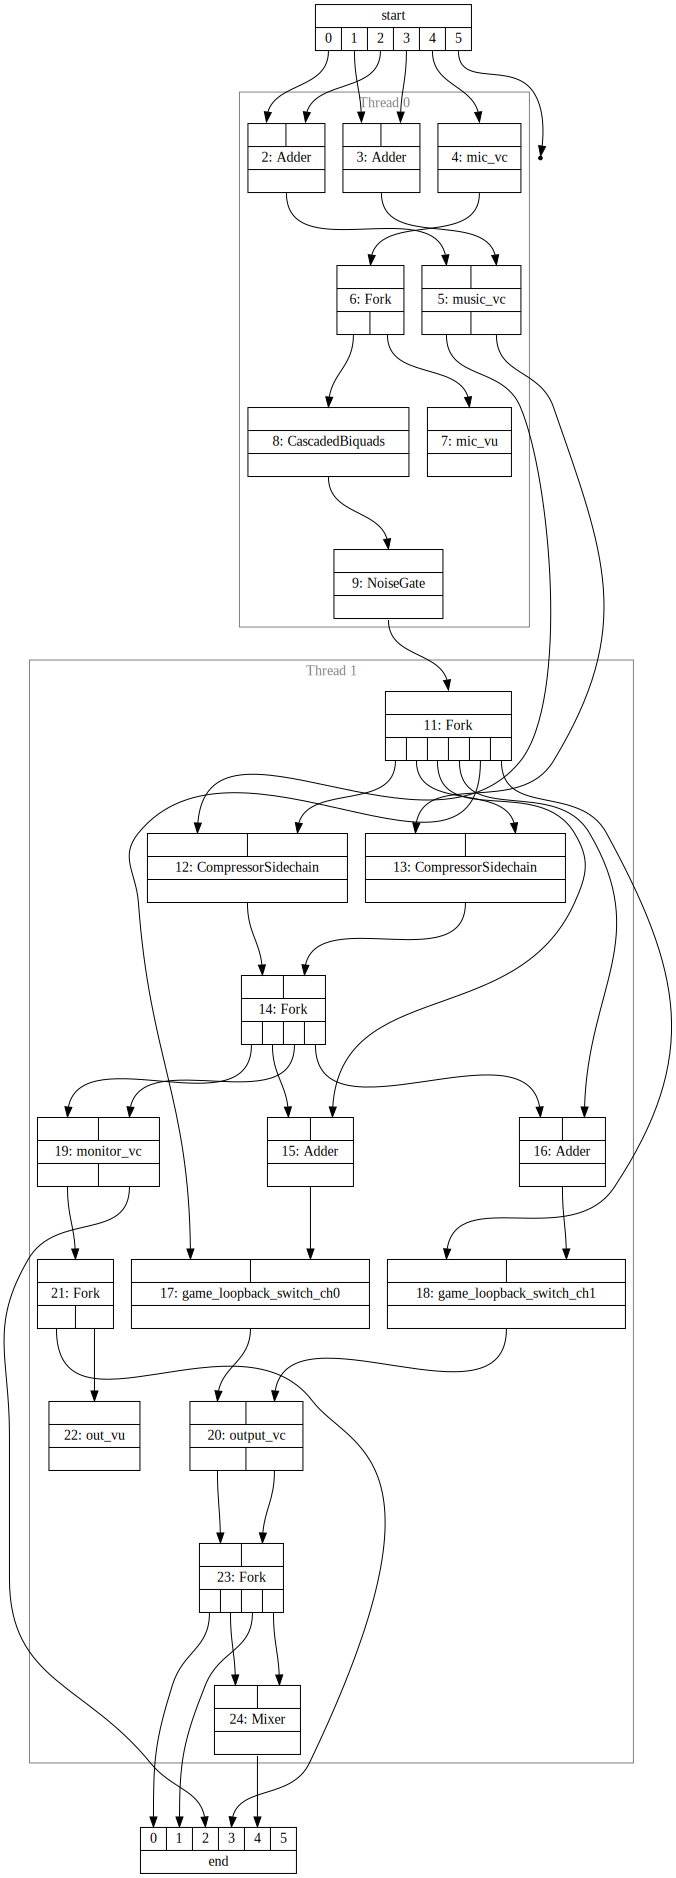

In [41]:
# Pipeline design stage

from audio_dsp.design.pipeline import Pipeline
from audio_dsp.stages.signal_chain import Fork, VolumeControl, Switch, Adder, Mixer, Bypass
from audio_dsp.stages.noise_gate import NoiseGate
from audio_dsp.stages.cascaded_biquads import CascadedBiquads
from audio_dsp.stages.compressor_sidechain import CompressorSidechain
from audio_dsp.stages.envelope_detector import EnvelopeDetectorRMS

# 6 inputs
# 0, 1: USB 
# 2, 3: live  (IN 1/2)
# 4   : Mic   (In 3)
# 5   : N/A
p = Pipeline(6)

with p.add_thread() as t:
    
#     b = t.stage(Bypass, p.i[:2])
# p.set_outputs(b.o + [None]*4)
    mus_0 = t.stage(Adder, [p.i[0], p.i[2]])
    mus_1 = t.stage(Adder, [p.i[1], p.i[3]])
    
    mic_vc = t.stage(VolumeControl, p.i[4], label="mic_vc")
    music_vc = t.stage(VolumeControl, mus_0.o + mus_1.o, label="music_vc")
    f_mic = t.stage(Fork, mic_vc.o)
    env_mic = t.stage(EnvelopeDetectorRMS, f_mic.forks[1], label="mic_vu")
    peq = t.stage(CascadedBiquads, f_mic.forks[0])
    ng = t.stage(NoiseGate, peq.o)

with p.add_thread() as t:
    f_ng = t.stage(Fork, ng.o, count=6)
    duck0 = t.stage(CompressorSidechain, [music_vc.o[0]] + f_ng.forks[0])
    duck1 = t.stage(CompressorSidechain, [music_vc.o[1]] + f_ng.forks[1])
    f_dck = t.stage(Fork, duck0.o + duck1.o)
    loopback_0 = t.stage(Adder, [f_dck.forks[1][0]] + f_ng.forks[2])
    loopback_1 = t.stage(Adder, [f_dck.forks[1][1]] + f_ng.forks[3])
    sw0 = t.stage(Switch, f_ng.forks[4] + loopback_0.o, label="game_loopback_switch_ch0")
    sw1 = t.stage(Switch, f_ng.forks[5] + loopback_1.o, label="game_loopback_switch_ch1")
    monitor_vc = t.stage(VolumeControl, f_dck.forks[0], label="monitor_vc")
    output_vc = t.stage(VolumeControl, sw0.o + sw1.o, label="output_vc")
    f_monvc = t.stage(Fork, monitor_vc.o[0])
    env_out = t.stage(EnvelopeDetectorRMS, f_monvc.forks[1], label="out_vu")
    f_output = t.stage(Fork, output_vc.o, count=2)
    live_out = t.stage(Mixer, f_output.forks[1])

# 0, 1: USB
# 2, 3: headphone (OUT 1/2)
# 4   : live      (OUT 3)
p.set_outputs(f_output.forks[0] + [monitor_vc.o[1]] + f_monvc.forks[0] + live_out.o + [None])
p.draw()


2. This is the tuning cell. First time through this can be ignored, but once your pipeline is running on a connected device, this cell can be updated and executed to update each pipeline stage live.

In [44]:
# Tuning stage

env_mic.make_env_det_rms(0.3, 0.3)
env_out.make_env_det_rms(0.3, 0.3)
peq.make_parametric_eq([["highpass", 50, 0.707]])
ng.make_noise_gate(-30, 0.005, 0.12)
duck0.make_compressor_sidechain(5, -30, 0.01, 0.5)
duck1.make_compressor_sidechain(5, -30, 0.01, 0.5)
sw0.move_switch(1)
sw1.move_switch(1)


3. This is the build and run cell. This stage generates an application which uses your pipeline, and it runs the application on a connected device using xrun. The tuning parameters set in the previous cell are baked in the application.

In [45]:
# Build and run

from audio_dsp.design.pipeline import generate_dsp_main
# from build_utils import build_and_try_run

generate_dsp_main(p, out_dir="src/audio_dsp/dsp_pipeline")
# build_and_try_run()
